## Harvard AI Bootcamp

## Stock Prediction Project
The Multivariate Time Series Forecasting project leverages Python and PyTorch and other essential libraries for data analysis and deep learning. The lab covers key steps, including data loading from Yahoo Finance, exploratory data analysis, preprocessing, model training, and performance evaluation. By focusing on the NASDAQ stock market index, the tutorial demonstrates the application of advanced techniques in time series forecasting. Readers are taken through the process of building, training, and evaluating a model, with a practical example predicting the next day's stock price. This tutorial serves as a valuable resource for those seeking hands-on experience in multivariate time series forecasting within the domain of financial markets.








## Make a copy of this notebook! Editing directly will not be saved.



# Step #1 Load the Data

In [1]:
import math

import numpy as np

import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
import torch
import yfinance as yf
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [6]:
# Setting the timeframe for the data extraction
end_date = date.today().strftime("%Y-%m-%d")
start_date = '2022-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = 'PLTR'
df = yf.download(symbol, start=start_date, end=end_date)

/tmp/ipython-input-1348937722.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


# Step #2 Exploring the Data

In [7]:

df.head(1000)

Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2023-01-03,6.390000,6.640000,6.275000,6.580000,29969900
2023-01-04,6.580000,6.675000,6.370000,6.480000,31660500
2023-01-05,6.320000,6.490000,6.250000,6.450000,34186000
2023-01-06,6.400000,6.450000,6.090000,6.400000,30596400
2023-01-09,6.500000,6.670000,6.400000,6.490000,31028900
...,...,...,...,...,...
2026-02-09,142.910004,145.869995,134.776001,136.580002,58042500
2026-02-10,139.509995,145.559998,137.770004,144.964996,56061300


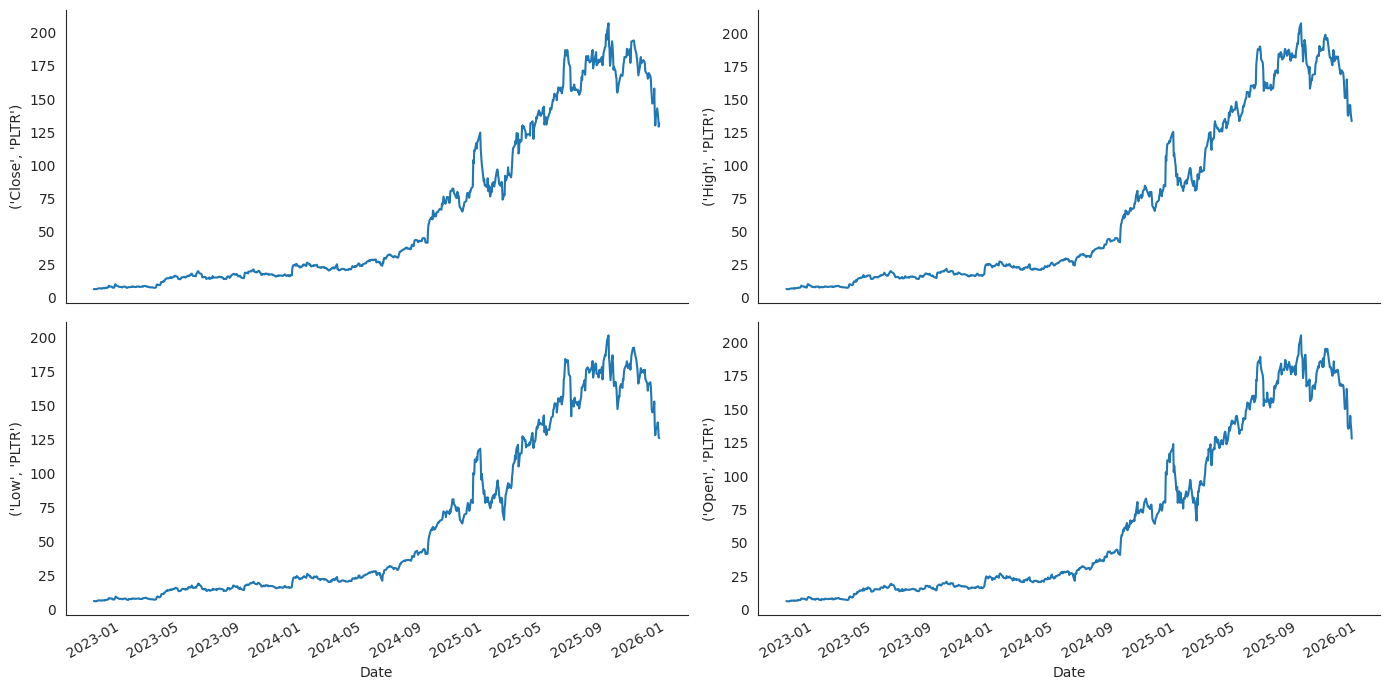

In [8]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [9]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])


FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


In [10]:
# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']


df.tail(100)

Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2026-02-02,147.759995,151.399994,146.654007,150.940002,72811100
2026-02-03,157.880005,165.078003,153.119995,165.050003,113169200
2026-02-04,139.539993,155.850006,135.679993,155.410004,113199500
2026-02-05,130.009995,137.979996,128.320007,136.820007,93690800
2026-02-06,135.899994,137.686996,132.350006,135.330002,62661400
2026-02-09,142.910004,145.869995,134.776001,136.580002,58042500
2026-02-10,139.509995,145.559998,137.770004,144.964996,56061300
2026-02-11,135.679993,139.250000,132.949997,139.024994,52796100


In [11]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(782, 5)


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

#The RNN needs data with the format of [samples, time steps, features]
#Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    #Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

#Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

#Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

#Validate that the prediction value and the input match up
#The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(576, 50, 5) (576, 1)
(156, 50, 5) (156, 1)
[0.00810663]
[0.00810663]


# Step #4 Model Training

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import math

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
     
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 10)
        
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [15]:
# Preprocessing steps (assuming data_filtered, and the train and test splits are done)
scaler = MinMaxScaler()
np_data_unscaled = np.array(data_filtered)
np_data_scaled = scaler.fit_transform(np_data_unscaled)

x_train, y_train = partition_dataset(sequence_length, train_data)  # Assuming partition_dataset is defined
x_test, y_test = partition_dataset(sequence_length, test_data)

n_neurons = x_train.shape[1] * x_train.shape[2]
input_size = x_train.shape[2]
hidden_size = n_neurons // 2
num_layers = 2
output_size = 1
learning_rate = 1e-4

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [16]:
# Convert to Torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 100
model.train()
for epoch in range(epochs):
    for x_batch, y_batch in train_dataloader:


        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Get the predicted values
y_pred_scaled = model(x_test)
y_pred_scaled_numpy = y_pred_scaled.detach().numpy()

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled_numpy)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:1077: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch [1/100], Loss: 0.1445
Epoch [2/100], Loss: 0.1071
Epoch [3/100], Loss: 0.0912
Epoch [4/100], Loss: 0.0734
Epoch [5/100], Loss: 0.0474
Epoch [6/100], Loss: 0.0091
Epoch [7/100], Loss: 0.0074
Epoch [8/100], Loss: 0.0057
Epoch [9/100], Loss: 0.0035
Epoch [10/100], Loss: 0.0030
Epoch [11/100], Loss: 0.0034
Epoch [12/100], Loss: 0.0028
Epoch [13/100], Loss: 0.0033
Epoch [14/100], Loss: 0.0016
Epoch [15/100], Loss: 0.0031
Epoch [16/100], Loss: 0.0010
Epoch [17/100], Loss: 0.0027
Epoch [18/100], Loss: 0.0007
Epoch [19/100], Loss: 0.0022
Epoch [20/100], Loss: 0.0005
Epoch [21/100], Loss: 0.0018
Epoch [22/100], Loss: 0.0005
Epoch [23/100], Loss: 0.0014
Epoch [24/100], Loss: 0.0005
Epoch [25/100], Loss: 0.0010
Epoch [26/100], Loss: 0.0005
Epoch [27/100], Loss: 0.0007
Epoch [28/100], Loss: 0.0005
Epoch [29/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0004
Epoch [31/100], Loss: 0.0005
Epoch [32/100], Loss: 0.0004
Epoch [33/100], Loss: 0.0004
Epoch [34/100], Loss: 0.0004
Epoch [35/100], Loss: 0

# Step #5 Evaluate Model Performance

In [17]:
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 8.5
Mean Absolute Percentage Error (MAPE): 4.87 %
Median Absolute Percentage Error (MDAPE): 4.15 %


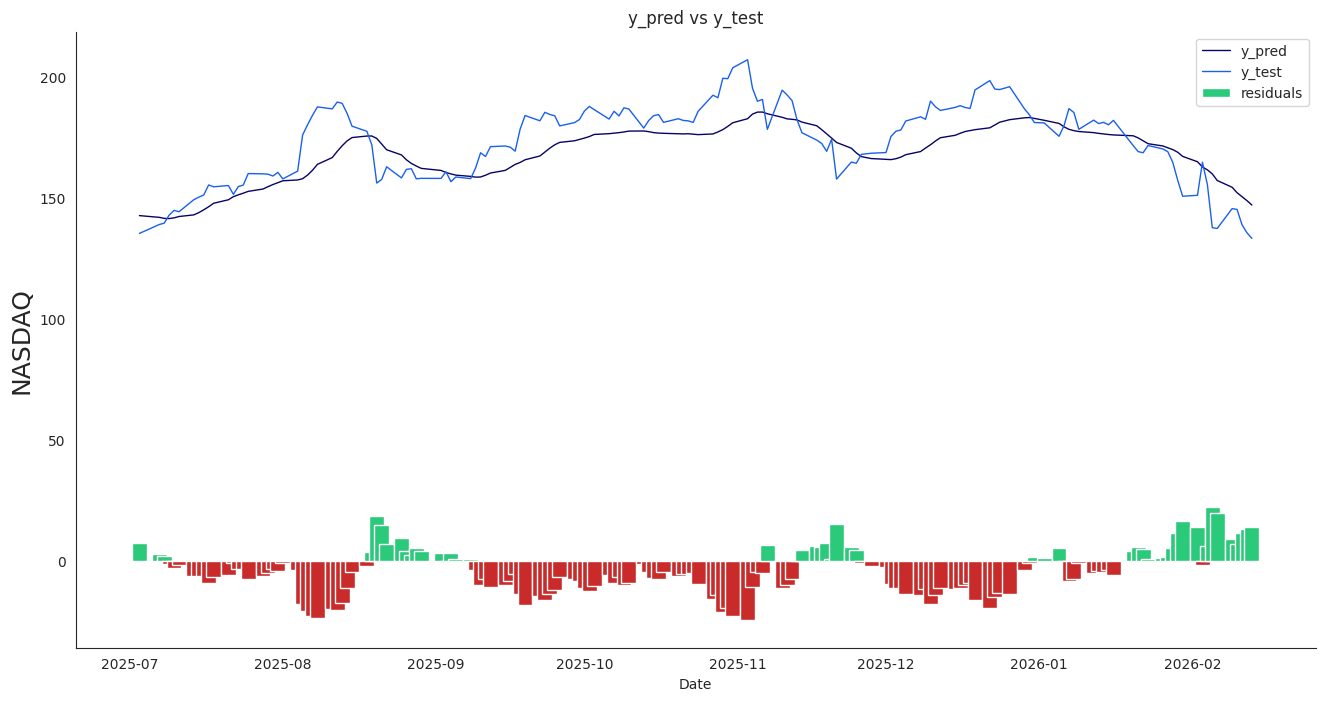

In [18]:
# The date from which on the date is displayed
display_start_date = "2019-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "y_test", y_test_unscaled, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [19]:
df_temp = df[-sequence_length:]
new_df = df_temp[FEATURES]

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test_new = torch.from_numpy(np.array(X_test_new)).float()

# Make predictions using the model
pred_price_scaled = model(X_test_new)
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.detach().numpy().reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'].iloc[-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2).iloc[0]

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today.iloc[0]}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for NASDAQ at 2026-02-15 was 131.41
The predicted close price is 145.1699981689453 (+9.48%)
